## Objective
The objective of this project is build a machine learning model that could accurately predict the likelyhood of a person would make a purchase or not. The model shall be built on a dataset containing the person's demography and income.

In [1]:
!uv pip install -r ../requirements.txt

Using Python 3.11.13 environment at: /home/azureuser/ws/genai/ml/ed_003/.venv
Audited 28 packages in 201ms


In [2]:
## Load the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [3]:
## Load the dataset
data = pd.read_csv('../extracted_data/social_network_ads_v2.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,No
1,15810944,Male,35,20000,No
2,15668575,Female,26,43000,No
3,15603246,Female,27,57000,No
4,15804002,Male,19,76000,No


In [7]:
# Drop the 'User ID' column as it is not needed for analysis
data.drop('User ID', axis=1, inplace=True)

In [8]:
## Perform basic data exploration
print("Dataset shape:", data.shape)
print("Columns:", data.columns)
print("Data types:\n", data.dtypes)     

Dataset shape: (400, 4)
Columns: Index(['Gender', 'Age', 'EstimatedSalary', 'Purchased'], dtype='object')
Data types:
 Gender             object
Age                 int64
EstimatedSalary     int64
Purchased          object
dtype: object


### Perform Analysis on Numerical Features

In [4]:
# Step1: Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
# Step2: Check for missing values
print("Missing values:\n", data.isnull().sum())     

Number of duplicate rows: 0
Missing values:
 User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64


In [5]:
# Step3: Perform basic statistical analysis
print("Descriptive statistics:\n", data.describe())     

Descriptive statistics:
             User ID         Age  EstimatedSalary
count  4.000000e+02  400.000000       400.000000
mean   1.569154e+07   37.655000     69742.500000
std    7.165832e+04   10.482877     34096.960282
min    1.556669e+07   18.000000     15000.000000
25%    1.562676e+07   29.750000     43000.000000
50%    1.569434e+07   37.000000     70000.000000
75%    1.575036e+07   46.000000     88000.000000
max    1.581524e+07   60.000000    150000.000000


In [6]:
# Step4: Check Skewness of 'Age' and 'EstimatedSalary'
import pandas as pd
print(data[['Age', 'EstimatedSalary']].skew())

Age                0.231337
EstimatedSalary    0.495024
dtype: float64


#### Numerical Data Analysis Findings - 1
- Both Age and EstimatedSalary has no null or missing values

- Mean Age is 37.65 and Median Age (i.e. 50%) is 37. Because mean and median is aligning, the Age data is symmetric
- Age Range (Max - Min) is 42. 
- Age IQR (75% - 25%) is 16.25. 
- Relative IQR = IQR/Median = 16.25/37 = 0.439 = 43.9% of the median
- 43.9% relative spread = moderate variation.

- Mean Salary is 69742.50 and Median Salary is 70000. Median is close to mean. Suggesting minimal skew.
- Salary Range (Max-Min) is 135K. 
- Salary IQR (75% - 25%) is 45K.
- Relative IQR = IQR/Median = 45K/70K = 0.643 = 64.3% of the median 
- 64% relative spread = high variation.

    - 

**Note:**

- High relative spread is fine if you are exploring or want to preserve natural differences, no action is needed. Many ML models (like tree-based models: Random Forest, XGBoost) handle varying spreads fine.

- If you’ll use distance-based models (e.g., KNN, SVM with RBF kernel, clustering) or linear models without regularization, then features with larger spreads can dominate. 

- Apply scaling (StandardScaler or MinMaxScaler).

- If the data is right-skewed, apply logarithim transformation first, and z-scaling if needed.

- If the data is left-skewed, right-skew it first and then apply logarithim transformation.

In [7]:
# Step5: Check outliers in 'Age' and 'EstimatedSalary'
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

age_outliers = detect_outliers_iqr(data['Age'])
salary_outliers = detect_outliers_iqr(data['EstimatedSalary'])

print(f"Age outliers count: {len(age_outliers)}")
print(f"Salary outliers count: {len(salary_outliers)}")

# Interpretation:
# If the count of outliers is significant, it may indicate that the data has extreme values
# that could affect the model's performance. Further investigation is needed to determine
# whether to remove or treat these outliers.    




Age outliers count: 0
Salary outliers count: 0


#### Numerical Data Analysis -2
- Age skewness is 0.23. It says faily symmetric.
- Age has no outlier. 
- Low skewness and no outlier. It means keep the data as is.

- Salary skewness is 0.49 (less than 0.5). It says faily symmetric.
- Salary has no outlier. 
- Low skewness and no outlier. It means keep the data as is.
  

**Skewness Interpretation:**
```
-   ≈ 0 → fairly symmetric
-   > 0.5 → moderate right skew
-   > 1 → strong right skew
-   < -0.5 → moderate left skew
-   < -1 → strong left skew
```

**Potential Insight:**
```
- High skew + many outliers → transform the data (e.g., log scale for salary).
- Low skew + few outliers → keep as is.
- Low skew + many outliers → check if outliers are real or data entry errors.
```

### Perform Analysis on Categorical Features

In [19]:
print(data['Gender'].value_counts(normalize=True) * 100)
print(data['Purchased'].value_counts(normalize=True) * 100)

Gender
Female    51.0
Male      49.0
Name: proportion, dtype: float64
Purchased
No     64.25
Yes    35.75
Name: proportion, dtype: float64


#### Categorical Data Analysis -1
- Gender has 51% Female and 49% Male. 
- Nearly perfectly balanced → no concern about gender imbalance in the dataset. 
- This is good for models — you won’t have bias simply from sampling imbalance.

- Purchased has 64.25% No, and 35.75% Yes. 
- The target variable is moderately imbalanced — about 2:1 ratio of “No” to “Yes.”
- Not extreme enough to require heavy rebalancing, but in classification tasks:
    - Consider using stratified sampling when splitting train/test.
    - Track metrics like precision, recall, F1 instead of just accuracy.


Distribution of 'Purchased':
 Purchased
No     257
Yes    143
Name: count, dtype: int64


<Axes: xlabel='Age', ylabel='count'>

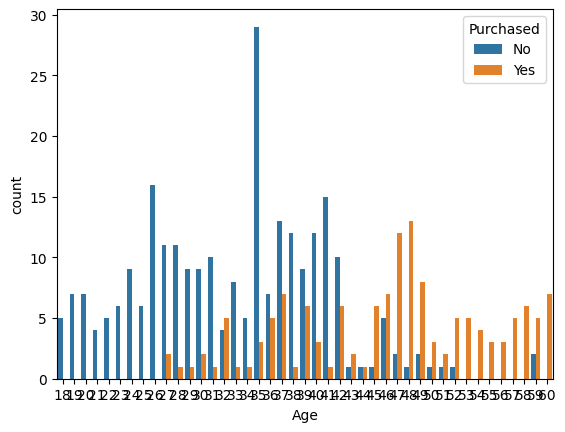

In [11]:
## Categogrical Data Analysis
# Check the distribution of the 'Purchased' column
print("Distribution of 'Purchased':\n", data['Purchased'].value_counts())
# Visualize the distribution of 'Age' and 'EstimatedSalary'
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Age', hue='Purchased', data=data)  

## Categorical Analysis Outcomes
- No imbalancing observed in Gender data.
- The target feature (Purchased) looks bit imbalanced with 65% No, and 35% yes. Because, this is target feature, consider using stratified sampling to avoid any biasing.
    - Track metrics like precision, recall, F1 instead of just accuracy.
- Age seems to have un-even impact.
    - Ages 18–40: Mostly No purchases, very few Yes.
    - Ages 45–60: Proportion of Yes increases noticeably.
    - Ages 50+: Purchases are more balanced, sometimes more Yes than No.
- Consider binning ages into groups (e.g., 18–25, 26–35, etc.) to reduce noise from small category counts.

# Potential Insight / Actions
- Since, we are going to use "LogisticRegression" algorithm, Its important to normalize the data.
- Apply logarithm scaling to remove the right-skewing from salary. And then apply the z-scaling. **Make this part of the ML pipeline**
- Use stratified sampling to avoid imbalancing in Purchased feature. stratified sampling ensures that equal portion of class is distributed between the training and testing data.
- Track metrics like precision, recall, F1 instead of just accuracy.